In [1]:
import pandas as pd
import zipfile
#from transformers import pipeline
import scipy.stats as stats
import numpy as np
import spacy
import seaborn as sns

In [2]:
def getDataFrameFromZip(filename, folder=""):
    with zipfile.ZipFile(f"{folder}{'/' if folder != '' else ''}{filename}.zip", "r") as zipfolder:
        with zipfolder.open(f"{filename}.jsonl", "r") as jsonlfile:
            return pd.read_json(jsonlfile, lines=True)

In [3]:
df = getDataFrameFromZip("processed_maincategories_1k7")

In [4]:
nlp = spacy.load("es_core_news_lg")

In [5]:
def lemmaPositions(text):
    analysis = nlp(text)

    lemmas = []
    for word in analysis:
        if word.pos_ in ("ADJ", "NOUN", "PROPN", "VERB"):
            lemmas.append((word.lemma_, word.idx))

    positions = {}
    for lemma, position in lemmas:
        if lemma not in positions.keys():
            positions[lemma] = []
        positions[lemma].append(position)

    return positions

In [262]:
df["lemmas"] = df["text"].apply(lemmaPositions)

In [263]:
df.to_json("lemmas_maincategories_1k7.jsonl", orient="records", lines="True")

In [7]:
# df = getDataFrameFromZip("lemmas_maincategories_1k7")

In [8]:
df.head()

,responsedatetime,source,url,title,author,categories,datetime,text,lemmas
0,2024-04-30 10:57:37,El Confidencial,https://www.elconfidencial.com/espana/2017-05-...,Pedro Sánchez gana con rotundidad las primaria...,None,[PSOE],2017-05-22 12:27:06,"Al 99,2% escrutado, los resultados de la web d...","{'escrutado': [9], 'resultado': [24, 3242, 379..."
1,2024-05-02 21:01:33,El Confidencial,https://www.elconfidencial.com/alma-corazon-vi...,'Chemsex': el fenómeno de drogas y sexo grupal...,None,[DROGAS],2017-06-05 12:18:00,"Consumo de todo tipo de estupefacientes, sexo ...","{'Consumo': [0], 'tipo': [16, 664], 'estupefac..."
2,2024-04-30 10:46:01,El Confidencial,https://www.elconfidencial.com/medioambiente/c...,"""Estamos en la era de la ebullición"": la adver...",Jorge García González,[CAMBIO CLIMÁTICO],2023-07-28 10:04:00,El mes de julio de 2023 está camino de convert...,"{'mes': [3, 798, 2173], 'julio': [10, 1750, 19..."
3,2024-05-02 21:02:49,El Confidencial,https://www.elconfidencial.com/espana/2023-11-...,La Policía baraja como hipótesis la autoría ir...,Alejandro Requeijo,[PP],2023-11-09 19:58:00,El exlíder del PP en Cataluña Alejo Vidal-Quad...,"{'exlíder': [3], 'PP': [15, 3341], 'Cataluña':..."
4,2024-05-02 21:12:59,El Confidencial,https://www.elconfidencial.com/espana/madrid/2...,Ayuso anuncia una nueva estación de la Línea 9...,I. S. Calleja,[PP],2022-10-04 10:28:00,La Comunidad de Madrid proyecta ya una nueva e...,"{'Comunidad': [3, 1650], 'Madrid': [16, 671, 8..."


In [9]:
def lemmaRelativeFrequenciesByCategoryHelper(row, dictionary):
    lemmas = 0
    for lemma in row["lemmas"].keys():
        lemmas = lemmas + len(row["lemmas"][lemma])


    for category in row["categories"]:
        if category not in dictionary.keys():
            dictionary[category] = {}

        for lemma in row["lemmas"].keys():
            if lemma not in dictionary[category].keys():
                dictionary[category][lemma] = []
            
            dictionary[category][lemma].append(len(row["lemmas"][lemma]) / lemmas)

def lemmaRelativeFrequenciesByCategory(df):
    frequencies = {}
    df.apply(lambda x: lemmaRelativeFrequenciesByCategoryHelper(x, frequencies), axis=1)
    return frequencies

In [10]:
relativeFrequencies = lemmaRelativeFrequenciesByCategory(df)

In [11]:
def purefrequencyDict(relativeFrequencies):
    dictionary = {}

    for category in relativeFrequencies.keys():
        dictionary[category] = {}
        for lemma in relativeFrequencies[category].keys():

            a = relativeFrequencies[category][lemma]
            b = []

            for category2 in relativeFrequencies.keys():
                if lemma in relativeFrequencies[category2].keys():
                    b.extend(relativeFrequencies[category2][lemma])
            
            fraction = np.mean(a)/np.mean(b)

            dictionary[category][lemma] = fraction
    
    return dictionary

def purefrequencyMatrix(relativeFrequencies):
    return pd.DataFrame.from_dict(purefrequencyDict(relativeFrequencies), orient="columns").sort_index(axis=1)

def frequencyMatrixToWordlist(matrix):
    return matrix.apply(lambda x: x.sort_values(ascending=False).index).sort_index(axis=1).reset_index(drop=True)

In [12]:
purefreqMatrix = purefrequencyMatrix(relativeFrequencies)

In [13]:
purefreq = frequencyMatrixToWordlist(purefreqMatrix)
purefreq

,ABORTO,CAMBIO CLIMÁTICO,CASA REAL,CIUDADANOS,COVID-19,CRISTIANISMO,DROGAS,EH BILDU,ERC,FRANQUISMO,...,JUNTS,PNV,PODEMOS,PP,PSOE,SINDICATOS,TERRORISMO,TOROS,VOX,YIHADISMO
0,practicado,F,despedido,by,comino,movilizar,japonés,vario,indebido,Águeda,...,Racismo,relajar,oliva,Sagrado,alga,constituyente,Andaluz,ponente,Guillem,furia
1,precepto,Badia,imperioso,olivo,elefante,Esther,inscribir él,manzana,sonreír,Majadahonda,...,mosca,expandir,reportera,suicidar él,Asensio,desprender él,nulidad,tonelada,Tiempo,portada
2,Portugal,crispación,entorpecer,magia,volante,jubilar,onda,podrido,escisión,Balmes,...,cineasta,himno,Josefina,resfriado,Arquitectura,Roja,retroactivo,aptitud,sarcasmo,austriaco
3,Trudeau,Argel,bombo,exponer él,1954,montar él,Secundaria,Bárcenas,Borges,conspiranoico,...,Tortosa,óseo,CSN,narrado,Ence,Mélenchon,Brooklyn,Dionisio,Fabián,Rousseau
4,impugnar,leche,Caixa,sempre,morgue,apretado,alumnado,Molina,exedil,gubernativo,...,delantero,arbitraje,Koch,Erra,Alberti,entonar,Ballesteros,soltero,Català,adentrar él
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134724,xilxes,xilxes,xilxes,xilxes,xilxes,xilxes,xilxes,xilxes,xilxes,xilxes,...,xilxes,xilxes,xilxes,xilxes,xilxes,xilxes,xilxes,Vèrtex,xilxes,xilxes
134725,Xiva,Xiva,Xiva,Xiva,Xiva,Xiva,Xiva,Xiva,Xiva,Xiva,...,Xiva,Xiva,Xiva,Xiva,Xiva,Xiva,Xiva,Galeria,Xiva,Xiva
134726,Frare,Frare,Frare,Frare,Frare,Frare,Frare,Frare,Frare,Frare,...,Frare,Frare,Frare,Frare,Frare,Frare,Frare,Gòtica,Frare,Frare
134727,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,...,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,Benaixeve,conselelra,Benaixeve,Benaixeve


In [267]:
def normalityDict(relativeFrequencies):
    dictionary = {}

    for category in relativeFrequencies.keys():
        dictionary[category] = {}
        for lemma in relativeFrequencies[category].keys():
            x = relativeFrequencies[category][lemma]
            if len(x) < 3:
                pvalue = np.nan
            else:
                pvalue = stats.shapiro(x).pvalue
            dictionary[category][lemma] = pvalue
    
    return dictionary

def normalityMatrix(relativeFrequencies):
    return pd.DataFrame.from_dict(normalityDict(relativeFrequencies), orient="columns").sort_index(axis=1)

In [268]:
normMatrix = normalityMatrix(relativeFrequencies)

C:\Users\Manuel Bonet\AppData\Local\Temp\ipykernel_19560\2073241982.py:11: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  pvalue = stats.shapiro(x).pvalue


<Axes: >

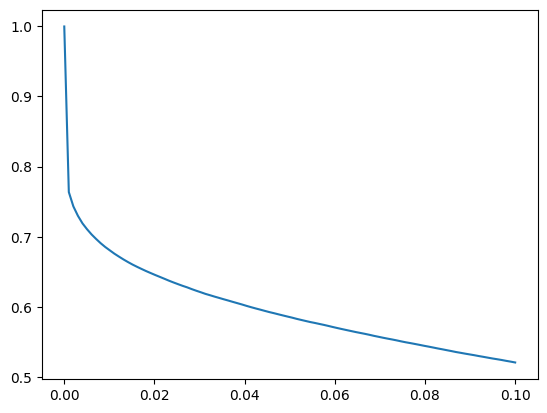

In [269]:
def fractionOfNormality(normMatrix, alpha):
    return normMatrix[normMatrix > alpha].count().sum()/normMatrix.count().sum()

x = np.linspace(0, 0.1, 100)
y = [fractionOfNormality(normMatrix, alpha) for alpha in x]

sns.lineplot(x=x, y=y)

In [270]:
def welchDict(relativeFrequencies, createNaN = False):
    dictionary = {}

    for category in relativeFrequencies.keys():
        dictionary[category] = {}
        for lemma in relativeFrequencies[category].keys():

            a = relativeFrequencies[category][lemma]
            b = []

            for category2 in relativeFrequencies.keys():
                if lemma in relativeFrequencies[category2].keys():
                    b.extend(relativeFrequencies[category2][lemma])
            
            pvalue = stats.ttest_ind(a, b, alternative="greater", equal_var=False).pvalue

            dictionary[category][lemma] = pvalue
    
    return dictionary

def welchMatrix(relativeFrequencies):
    return pd.DataFrame.from_dict(welchDict(relativeFrequencies), orient="columns").sort_index(axis=1)

In [282]:
# welch = welchMatrix(relativeFrequencies)

c:\Users\Manuel Bonet\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1081: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Manuel Bonet\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1081: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Manuel Bonet\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [272]:
# welch.to_csv("welch_pvalues_maincategories_1k7.csv")

In [273]:
def mannwhitneyDict(relativeFrequencies):
    dictionary = {}

    for category in relativeFrequencies.keys():
        dictionary[category] = {}
        for lemma in relativeFrequencies[category].keys():

            a = relativeFrequencies[category][lemma]
            b = []

            for category2 in relativeFrequencies.keys():
                if lemma in relativeFrequencies[category2].keys():
                    b.extend(relativeFrequencies[category2][lemma])
            
            pvalue = stats.mannwhitneyu(a, b, alternative="greater", use_continuity=False).pvalue

            dictionary[category][lemma] = pvalue
    
    return dictionary

def mannwhitneyMatrix(relativeFrequencies):
    return pd.DataFrame.from_dict(mannwhitneyDict(relativeFrequencies), orient="columns").sort_index(axis=1)

In [274]:
mannwhitney = mannwhitneyMatrix(relativeFrequencies)

In [275]:
mannwhitney.to_csv("mannwhitney_pvalues_maincategories_1k7.csv")

In [276]:
def pvalueMatrixToWordlist(matrix):
    return matrix.apply(lambda x: x.sort_values().index).sort_index(axis=1).reset_index(drop=True)

In [277]:
# welchwordlist = pvalueMatrixToWordlist(welch)
# welchwordlist.head(20)

,PSOE,DROGAS,CAMBIO CLIMÁTICO,PP,IMPUESTOS,CRISTIANISMO,PODEMOS,INMIGRACIÓN,SINDICATOS,GUERRA EN UCRANIA,...,JUNTS,INDEPENDENTISMO,EH BILDU,COVID-19,CIUDADANOS,IU,YIHADISMO,ABORTO,ERC,TOROS
0,Gobierno,Fronteras,regidor,PP,declaración,Caracas,Podemos,orgánico,TJUE,guerra,...,2002,endeudamiento,Denis,caso,Ciudadanos,punta,predecir,Adolfo,Robert,reconstrucción
1,Sánchez,okupa,l,Langreo,impuesto,Francisco,sumar,interesante,concreción,país,...,Puigdemont,fleco,Bildu,persona,partido,particularidad,arropado,tesis,ERC,explosivo
2,socialista,agente,cambio,Madrid,Hacienda,vetado,Díaz,persona,Islas,quiniela,...,Administrativo,emanar,boicotear,día,localización,Confidencial,enseñanza,mujer,pasividad,eclipsar
3,PSOE,efecto,Coloma,popular,euros,buscado,terminología,Teatro,cortado,Ucrania,...,Socialistas,Cataluña,respirar,semana,AfD,tremendo,diferenciar,derecho,politizado,destrozar
4,presidente,Institute,niebla,Ayuso,año,1988,queso,inmigrante,sindicato,bulto,...,catalán,dialogado,ilusionar,medida,Rivera,solventar,interlocutor,aborto,acertar,envite
5,Pedro,consumo,climático,detonación,renta,abuso,Lengua,país,trabajador,militar,...,Junts,disimular,dual,mayor,encarnizado,IU,tabú,anticonstitucional,Luisa,tarde
6,química,droga,versión,sopa,presentar,cirujano,Barcelona,llegar,enfado,sonreir,...,guiado,catalán,EH,positivo,educadora,1936,Rafael,venta,Fuente,plaza
7,repatriar,crucial,eléctrico,Feijóo,Agencia,Iglesia,aeroportuario,santuario,Alto,ruso,...,Torra,guardado,infame,último,fructífero,cannabis,Estado,minimizar,subdirector,mano
8,general,dudoso,global,despistado,pagar,San,formación,frontera,empresa,Rusia,...,apasionado,octubre,PNV,situación,patrullar,meter él,ordinario,ley,palabrería,colar
9,apropiar él,búnker,Tapia,presidenta,complicidad,Stefan,Unidas,columna,perdón,Recursos,...,presidente,independencia,calmar,pandemia,exmujer,ESPAÑOL,terrorista,Familias,remoto,tristeza


In [278]:
mannwhitneywordlist = pvalueMatrixToWordlist(mannwhitney)
mannwhitneywordlist.head(20)

,PSOE,DROGAS,CAMBIO CLIMÁTICO,PP,IMPUESTOS,CRISTIANISMO,PODEMOS,INMIGRACIÓN,SINDICATOS,GUERRA EN UCRANIA,...,JUNTS,INDEPENDENTISMO,EH BILDU,COVID-19,CIUDADANOS,IU,YIHADISMO,ABORTO,ERC,TOROS
0,Gobierno,agente,cambio,PP,declaración,Francisco,Podemos,persona,sindicato,guerra,...,Puigdemont,Cataluña,Bildu,caso,Ciudadanos,IU,Estado,mujer,ERC,plaza
1,Sánchez,efecto,climático,Madrid,euros,abuso,sumar,país,trabajador,país,...,catalán,catalán,EH,persona,partido,izquierda,terrorista,derecho,republicano,tarde
2,socialista,droga,versión,popular,impuesto,Iglesia,Díaz,inmigrante,empresa,militar,...,Cataluña,octubre,vasco,día,Rivera,Izquierda,grupo,aborto,mesa,mano
3,PSOE,consumo,agua,Rajoy,fiscal,católico,Barcelona,llegar,huelga,Ucrania,...,Junts,independentista,PNV,medida,Albert,Podemos,país,ley,catalán,buen
4,presidente,tráfico,global,Ayuso,pagar,San,formación,extranjero,servicio,ruso,...,independencia,independencia,definir,mayor,liberal,coalición,atentado,vida,común,gran
5,Pedro,operación,motor,presidenta,millón,religioso,Iglesias,frontera,colectivo,Rusia,...,causa,Estado,Otegi,semana,Arrimadas,coordinador,ataque,estado,Junts,primero
6,general,detener,eléctrico,Feijóo,Hacienda,Jesús,Yolanda,costa,salario,ataque,...,Torra,Generalitat,dignidad,positivo,censura,carne,operación,asociación,Aragonès,José
7,secretario,registro,coche,presidente,renta,víctima,Unidas,Italia,sector,conflicto,...,independentista,político,abertzale,total,diputado,Asturias,seguridad,embarazo,presupuesto,toro
8,reflexionar,criminal,planeta,Comunidad,año,siglo,lista,menor,compañía,occidental,...,presidente,Barcelona,recordar él,pandemia,Cs,Garzón,francés,interrupción,independencia,grande
9,Zapatero,consumir,especie,hablar,presentar,mundo,morado,España,sindical,UE,...,Generalitat,testigo,asesinato,situación,naranja,federal,estadounidense,Supremo,negociación,quinto


In [283]:
mannwhitneywordlist.to_csv("mannwhitney_wordlist_maincategories_1k7.csv")